In [1]:
# Building code to train an NLP model for financial products with "datasimilar" financial descriptions from Consumer Finance Products Bureau 

# BAT Imports for CFPB data collection, visualization, EDA and preparation
import pandas as pd
#import requests
import numpy as np
import string
import io
import urllib.parse
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as metrics 
from IPython.display import display, HTML

#install tensorflow.keras packages 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model # Remove if unused
#from tensorflow.keras.layers import Embedding ## Change to all at once ?
from tensorflow.keras.layers import Embedding, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPool1D, Bidirectional, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping 

print('Loaded')

Loaded


# Data Collection
CFPB API call to retrieve dataset - download a file for designated date range into a pandas Dataframe

## Data Collection - Acquistion
Retrieving the CFPB financial product complaints "datasimilar" dataset to be used for NLP training:   
 - Helper function call_cfpb() will structure URL and tags to retrieve a date range for 2021 as a CSV file   
 - When GET from CFPB is sucessful, the helper function will convert the CSV file to a panda dataframe using pd.read_csv()

## Data Collection and Extraction - Validation
An ethical approach to data research with consumer data requires confirmation of consent:
 - The check_consent() helper function validates consent was obtained for the CFPB records being used in the project
 - If there are any records without consent, they are returned by the helper function
 - No consents were missing from the 2021 records in the data collected in the CFPD "df" dataframe

In addition to validating consent, an additional function checks to see if there are missing values:
 - The check_nan() function determines if there are NaN(s), which is a pandas missing value designator
 - A conditional message is printed depending on the outcome  The research dataset is not missing any values
 - The research dataset is not missing any values



In [2]:




### Data validation Helper functions - confirm Consumer consent inclusions for dataset and perform a missing value (NaN) check

#Confirm all complaints in dataset have a consumer consent to publicly share CFPB complaint
def check_consent(df):
    consent_mask=df['Consumer consent provided?']!='Consent provided'
    missing_consent = df[consent_mask]
    if missing_consent.empty is True:
        print('All Consumer consents provided for CFPB records')
    else: 
        print(f'The following records do not have consent: {missing_consent}')
    print('\n')

# NaN check of dataframe
def check_nan(df):
    if df.isnull().values.any() is True: # pandas check for NaN
        print ("There are missing values in the dataframe")
    else:
        print ("No missing values in CFPB dataframe")    


In [3]:
## Data Collection - Acquisition of complaints dataset from the Consumer Finance Protection Bureau

# Helper functions and request code for Data Collection

### Data acquisition Helper function that calls CFPB API and retrieves dataset file by date range

def call_cfpb(api_url, date_max, date_min, format ):
    tags = {'date_received_max': date_max, #string yyyy-mm-dd
              'date_received_min': date_min, #string yyyy-mm-dd
              'format': format, #example - 'csv'
              'has_narrative': 'true' # retrieves product complaints with narrative text 
                }
    get_url = api_url + urllib.parse.urlencode(tags)
    df = pd.read_csv(get_url)
    return df

# CFPD API URL
cfpd_v1_url = 'https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?'

# Function call using the API url, date range with maximum and minimum dates, and file type
df = call_cfpb(cfpd_v1_url, '2021-12-31', '2021-01-01', 'csv')

print(f'Retrieved CFPD dataset row & column counts:{df.shape}')
print(end='\n')
print('Retrieved pandas df column names and types:', end='\n')
print(df.dtypes)

Retrieved CFPD dataset row & column counts:(203593, 18)

Retrieved pandas df column names and types:
Date received                    object
Product                          object
Sub-product                      object
Issue                            object
Sub-issue                        object
Consumer complaint narrative     object
Company public response          object
Company                          object
State                            object
ZIP code                         object
Tags                             object
Consumer consent provided?       object
Submitted via                    object
Date sent to company             object
Company response to consumer     object
Timely response?                 object
Consumer disputed?              float64
Complaint ID                      int64
dtype: object


In [ ]:
#pd.DataFrame(df).to_csv("cfpd_2021.csv")
# for reloading if needed...

In [4]:
# Data Collection and Data Extraction - Validation 
# Data extraction validation Helper functions to confirm Consumer consent inclusions for Complaint dataset and a missing value (NaN) check

#Confirm all complaints in dataset have a consumer consent to publicly share CFPB complaint
def check_consent(df):
    consent_mask=df['Consumer consent provided?']!='Consent provided'
    missing_consent = df[consent_mask]
    if missing_consent.empty is True:
        print('All Consumer consents provided for CFPB records')
    else: 
        print(f'The following records do not have consent: {missing_consent}')
    print('\n')

# NaN check of dataframe
def check_nan(df):
    if df.isnull().values.any() is True: # pandas check for NaN
        print ("There are missing values in the dataframe")
    else:
        print ("No missing values in CFPB dataframe")    

# 1) The project has an ethical approach to the research project, checking confirmation the right permissions were obtained for the data.
# CFPB has a Consumer consent column confirming verification of consent on all records. The check_consent() function confirms all complaints 
# in the dataframe have a supplied consent to publicly share CFPB complaint.
check_consent(df)

# 2) Missing value check: As part of the validation process, calling a Helper function to perform a NaN check of the dataframe
check_nan(df)


All Consumer consents provided for CFPB records


No missing values in CFPB dataframe


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1,08/11/21,Debt collection,Mortgage debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,New mortgage investor JP Morgan Chase refuse t...,None,JPMORGAN CHASE & CO.,NV,89121,None,Consent provided,Web,08/11/21,Closed with explanation,Yes,NaN,4621866
2,12/16/21,"Money transfer, virtual currency, or money ser...",Virtual currency,Other transaction problem,None,"Dear Sir or Madam, I do have a record of all e...",None,"Coinbase, Inc.",PA,18951,Servicemember,Consent provided,Web,01/21/22,Closed with explanation,Yes,NaN,5015462
3,11/16/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,None,I applied to Better Mortgage Corporation to re...,None,"Better Mortgage, Inc.",DE,19962,Older American,Consent provided,Web,11/16/21,Closed with explanation,No,NaN,4914250
4,11/01/21,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,I received an forthright answer from Mr. Coope...,None,NATIONSTAR MORTGAGE,MI,48090,None,Consent provided,Web,11/16/21,Closed with explanation,Yes,NaN,4864353
5,10/19/21,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,I am well aware of your statements XXXX XXXX X...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",MI,48090,None,Consent provided,Web,10/19/21,Closed with explanation,Yes,NaN,4822889
6,11/18/21,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,Frontier Airlines closed my Frontier Barclays ...,Company has responded to the consumer and the ...,BARCLAYS BANK DELAWARE,CO,81201,None,Consent provided,Web,12/06/21,Closed with explanation,Yes,NaN,4922018
7,11/11/21,Mortgage,Home equity loan or line of credit (HELOC),Applying for a mortgage or refinancing an exis...,None,BBVA now PNC was under valuing housing/ proper...,None,PNC Bank N.A.,TX,77005,None,Consent provided,Web,12/02/21,Closed with explanation,Yes,NaN,4897812
8,02/09/21,"Payday loan, title loan, or personal loan",Title loan,Can't contact lender or servicer,None,In XXXX of XXXX I sent a message to M & T Bank...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,CO,80543,None,Consent provided,Web,02/09/21,Closed with explanation,Yes,NaN,4127874
9,11/17/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,None,This company falsely advertised on their XXXX ...,None,"Better Mortgage, Inc.",MO,65203,None,Consent provided,Web,11/17/21,Closed with explanation,No,NaN,4922986
10,12/29/21,Debt collection,I do not know,Communication tactics,"You told them to stop contacting you, but they...",Advance America has been contacting me 3-4 tim...,None,"Advance America, Cash Advance Centers, Inc.",LA,71202,None,Consent provided,Web,12/29/21,Closed with explanation,No,NaN,5051212



Product label values in CFPB retrieval by Count:


Credit reporting, credit repair services, or other personal consumer reports    109186
Debt collection                                                                  34504
Credit card or prepaid card                                                      16608
Mortgage                                                                         14078
Checking or savings account                                                      12401
Money transfer, virtual currency, or money service                                7966
Vehicle loan or lease                                                             4286
Payday loan, title loan, or personal loan                                         2389
Student loan                                                                      2175
Name: Product, dtype: int64

<AxesSubplot:title={'center':'Complaint Count by Product label'}>

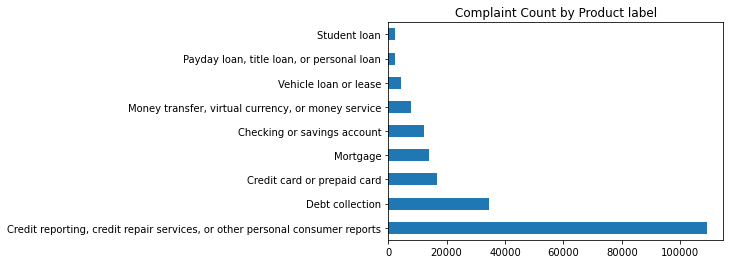

In [5]:
# Data Extraction and Preparation

# 3) EDA with a full scrollable dataframe using df.to_html() and display(HTML) to use for data exploration
# Helper function for scrollable dataframe display using df.to_html() for data exploration, add column_fill: auto;
def scroll_eda(df):
    display(HTML("<div style='height: 400px;  overflow: auto; width: fit-content'>" +
             df.to_html(notebook=True) +
             "</div>"))

# EDA discovery work for extraction and preparation decisions:
# Explore "Consumer complaint narrative" text and othe CFPB dataset row and column values using scroll_eda(),
# which uses the pandas .to_html() function for viewing. 
# Exporting the Jupyter Notebook to HTML also allows the EDA with just a web brower.
scroll_eda(df)

# 4) Look at the counts of Product label values in the CFPB complaints dataframe
%matplotlib inline
print(end='\n')
# Explorations of CFPB dataset with focus on the category labels of the complaint narratives, which are the "Product" values.
print('Product label values in CFPB retrieval by Count:')
display(df.Product.value_counts())
df.Product.value_counts().plot(title='Complaint Count by Product label', kind='barh')


CFPB Product: Credit reporting, credit repair services, or other personal consumer reports.
count            109186
unique             1271
top       EQUIFAX, INC.
freq              40817
Name: Company, dtype: object


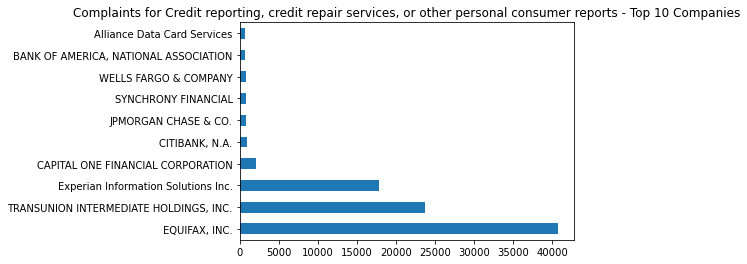


CFPB Product: Debt collection.
count                                 34504
unique                                 1869
top       PORTFOLIO RECOVERY ASSOCIATES INC
freq                                   1575
Name: Company, dtype: object


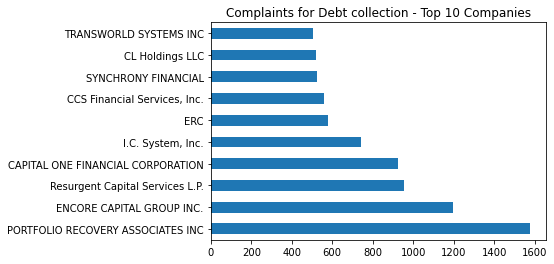


CFPB Product: Credit card or prepaid card.
count                                 16608
unique                                  226
top       CAPITAL ONE FINANCIAL CORPORATION
freq                                   2220
Name: Company, dtype: object


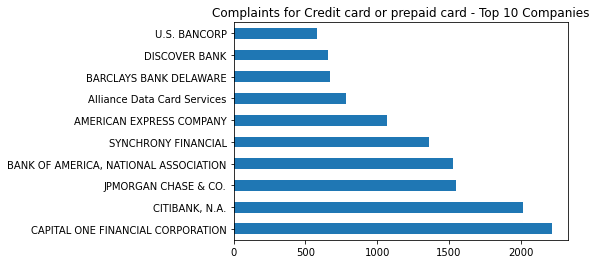


CFPB Product: Mortgage.
count                   14078
unique                    613
top       NATIONSTAR MORTGAGE
freq                      983
Name: Company, dtype: object


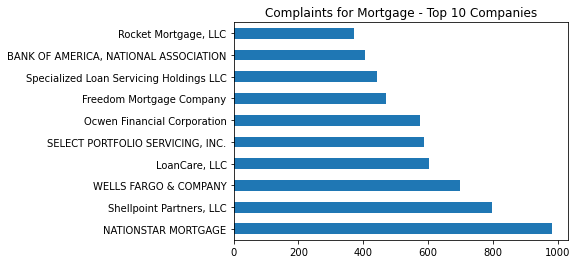


CFPB Product: Checking or savings account.
count                                     12401
unique                                      222
top       BANK OF AMERICA, NATIONAL ASSOCIATION
freq                                       1586
Name: Company, dtype: object


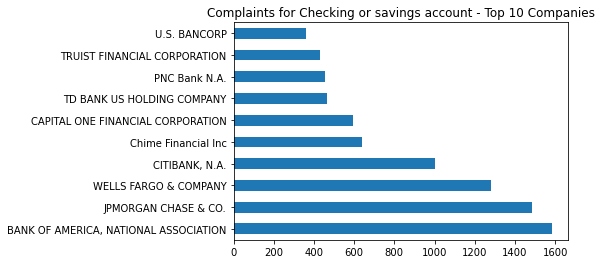


CFPB Product: Money transfer, virtual currency, or money service.
count                     7966
unique                     255
top       Paypal Holdings, Inc
freq                      2185
Name: Company, dtype: object


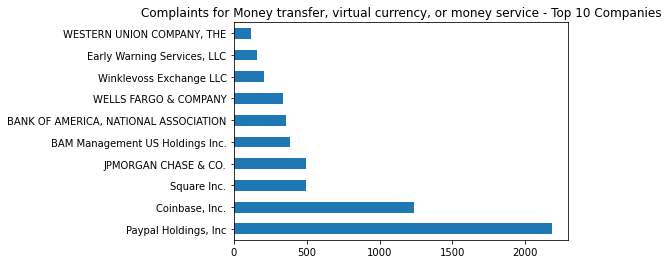


CFPB Product: Vehicle loan or lease.
count                                     4286
unique                                     251
top       Santander Consumer USA Holdings Inc.
freq                                       489
Name: Company, dtype: object


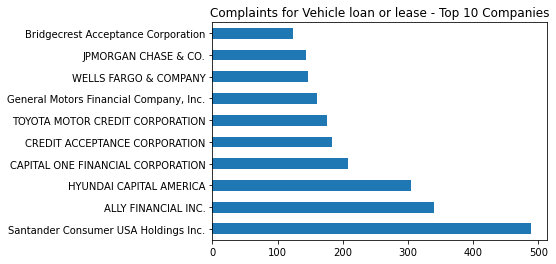


CFPB Product: Payday loan, title loan, or personal loan.
count                            2389
unique                            338
top       OneMain Finance Corporation
freq                              127
Name: Company, dtype: object


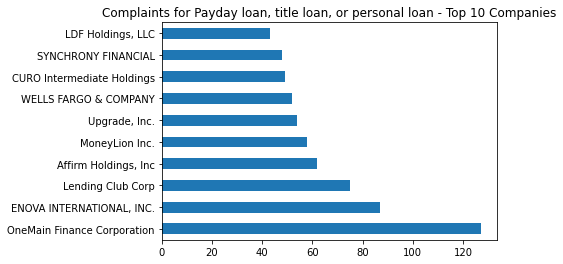


CFPB Product: Student loan.
count                        2175
unique                        130
top       Navient Solutions, LLC.
freq                          662
Name: Company, dtype: object


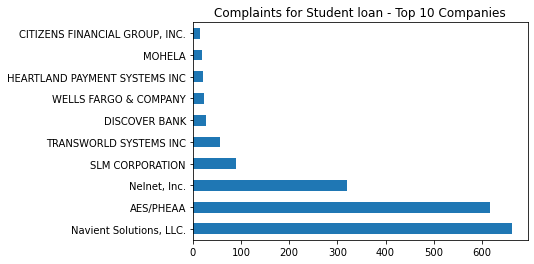


Done


In [6]:
# 5) Deep dive into Product complaints, specifically
# BAT Detailed EDA Helper function, fp(i,df) that changes dataframe index to Product,
# and will iterate through i, which is a set of Products, and return the following:

def fp(i, df): #new version
    # df_pi should be new dataframe not a shallow copy of df...
    df_pi = df.set_index("Product") 
    print(f'CFPB Product: {i}.')
    print(df_pi.loc[i].Company.describe())
    df_pi.loc[i].Company.value_counts()[:10].plot(title='Complaints by Product by Company:Top 10', kind='barh')
    plt.title(f'Complaints for {i} - Top 10 Companies')
    plt.show()
    print( end='\n')

#  Using fp(i,df) to run functions on Company column as index for a Product that shows counts to help identify potential 
#  Company associated stopwords to include in cleaning complaint narrative. There are two outputs
# - a describe() for specific CFPB Product, the descriptive statistics, and the Company that is most commonly referenced in the Product complaints.
# - a plot showing the complaints count for the Top 10 Companies for that Product category label 
products = []
products = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Credit card or prepaid card', 'Mortgage', 'Checking or savings account', 'Money transfer, virtual currency, or money service','Vehicle loan or lease', \
'Payday loan, title loan, or personal loan','Student loan']

[fp(prod, df) for prod in products]

print("Done")


In [38]:
## 6) Identify the prevalence of redaction replacement text (e.g. 'XXXX') in the "Consumer complaint narrative",
#     and determine if the use is widespread enough that it should be included in custom stop words

def check_redactions(df):
    ## test the DataFrame for redaction patterns in "Consumer complaint narrative"
    test_df = df['Consumer complaint narrative']
    redact_mask=test_df.str.contains('XXXX|XX/XX/XXXX|XX/XX', na=False)
    redact_any= any(redact_mask)
    if redact_any is True:
        redact_trues = sum(redact_mask)
        print(f'There are {redact_trues} complaint narrative rows with redactions out of {len(redact_mask)} total rows!')
        print("IMPORTANT: This means redact_mask text should be considered for inclusion in the custom stop word list.")
    else: print("No redactions using redact mask in dataset complaint narratives.")
    
#Check redactions on this CFPB dataframe with complaints narrative column and check results

check_redactions(df)


There are 159498 complaint narrative rows with redactions out of 203593 total rows!
IMPORTANT: This means redact_mask text should be considered for inclusion in the custom stop word list.


In [40]:
# Large financial institution (e.g., crosses products) company name check

def check_institutions(df):
    ## test the DataFrame for institutions mentioned in "Consumer complaint narrative"
    test_df = df['Consumer complaint narrative']
    institution_mask=test_df.str.contains('Wells|Fargo|Capital|BOA|Chase|JPmorgan|JPMCB|Citibank|citibank|CFPB|Truist|One', na=False)
    check_any= any(institution_mask)
    if check_any is True:
        check_trues = sum(institution_mask)
        print(check_trues)
        print(f'There are {check_trues} complaint narrative rows with institutions out of {len(institution_mask)} total rows!')
    else: print("No large financial institutions mentioned in dataset complaint narratives.")

check_institutions(df)

24186
There are 24186 complaint narrative rows with instituions out of 203593 total rows!


In [46]:
#7 EDA - determine if "Consumer complaint narrative" has any emoticons
# or foreign characters that need to be added to tf.keras exclusion list

import nltk
import nltk.tokenize.casual as emo

def check_characters(df):
    ## test the DataFrame for emoticons and and other unusual characters in "Consumer complaint narrative"
    test_df = df['Consumer complaint narrative']
    #cf_unusuals = []
    cf_foreign =[]
    cf_emojis = []
    for x in test_df: # x is row, i is character
        for i in x:
            if i not in string.printable: 
                cf_foreign.append(i)

        emos = emo.EMOTICON_RE.findall(x) # emoji/emoticon identification resource
        if emos: cf_emojis.append(emos)
    cf_unusuals = cf_emojis.append(cf_foreign)
    cf_unusuals = pd.Series(cf_unusuals)
    if cf_unusuals.empty is True:
        print('No foreign charactors or emojis in CFPD Complaint text')
    elif cf_foreign:
        print(f'Here are the foreign characters: {cf_foreign}')
    else: 
        print(f'Here are the emoticons: {cf_emojis}') 
            

# Code block invoking check_characters() function
check_characters(df)


No foreign charactors or emojis in CFPD Complaint text


C:\Users\bradt\AppData\Local\Temp/ipykernel_2044/1752850209.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cf_unusuals = pd.Series(cf_unusuals)


In [8]:
# CFPB data preparation of pandas columns for multi-classification analysis narrative text and training preparation
df_mc = df.copy()

df_mc.drop(labels=['Date received', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', \
'Submitted via',  'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?'], axis=1, inplace=True)  #make drops inplace without name change

display(df_mc.shape)
print('df_mc after column names drop:', end='\n')
print(df_mc.dtypes)


(203593, 3)

df_mc after column names drop:
Product                         object
Consumer complaint narrative    object
Complaint ID                     int64
dtype: object


In [ ]:
print(df.dtypes)

In [9]:
# Before sw and clean up: Continue exploration of CFPB complaint narrative dataframe

# Descriptive statistics for key features
def narrative_stats(df):
    mean_df = df.groupby(['Product']).describe().loc[:,(slice(None),['mean'])].reset_index()
    min_max_df = df.groupby(['Product']).describe().loc[:,(slice(None),['min', 'max'])].reset_index()
    all_stats = pd.concat( [mean_df, min_max_df], axis=1)
    return all_stats

# Continue exploration of CFPD narrative var for word count per complaint
def word_count(df):
    wc_df = df
    # count total words in narrative and enter in dataframe
    wc_list = [len(w.split()) for w in wc_df['Consumer complaint narrative'].tolist() ]
    wc_df['word_count'] = wc_list
    return wc_df



df_x_id=df_mc.drop(labels=['Complaint ID'], axis=1, inplace=False)

# Return shows word_count added.

display(word_count(df_x_id))

# Key descriptive statistics for use in determining sequence length, 
# truncation, and padding, e.g. max_len = x 

display(narrative_stats(df_x_id))



,Product,Consumer complaint narrative,word_count
0,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,99
1,Debt collection,New mortgage investor JP Morgan Chase refuse t...,85
2,"Money transfer, virtual currency, or money ser...","Dear Sir or Madam, I do have a record of all e...",420
3,Mortgage,I applied to Better Mortgage Corporation to re...,380
4,"Credit reporting, credit repair services, or o...",I received an forthright answer from Mr. Coope...,184
...,...,...,...
203588,"Credit reporting, credit repair services, or o...",I am XXXX XXXX and I am submitting this compla...,123
203589,Debt collection,RE : Attentively review my formal writ compose...,961
203590,"Credit reporting, credit repair services, or o...",I am writing to dispute the following informat...,91
203591,"Credit reporting, credit repair services, or o...",I have tried to send my disputes to the major ...,30


Product  word_count  \
                                                            mean   
0                        Checking or savings account  240.664866   
1                        Credit card or prepaid card  223.593088   
2  Credit reporting, credit repair services, or o...  144.513839   
3                                    Debt collection  198.445745   
4  Money transfer, virtual currency, or money ser...  216.612101   
5                                           Mortgage  294.623597   
6          Payday loan, title loan, or personal loan  222.385098   
7                                       Student loan  239.896092   
8                              Vehicle loan or lease  251.706253   

                                             Product word_count          
                                                            min     max  
0                        Checking or savings account        4.0  5370.0  
1                        Credit card or prepaid card        3.0  3708.0  
2  Credit reporting, credit repair services, or o...        2.0  4628.0  
3                                    Debt collection        2.0  5547.0  
4  Money transfer, virtual currency, or money ser...        4.0  5186.0  
5                                           Mortgage        2.0  5072.0  
6          Payday loan, title loan, or personal loan        6.0  2786.0  
7                                       Student loan        3.0  3042.0  
8                              Vehicle loan or lease        5.0  3920.0

In [10]:
## Create a combination of NLTP English and CFPB specific stopwords using the function cfpb_stopwords()
## The list includes custom values for redaction masks and specific company names identified by EDA during Data Extraction and Preparation 

#nltk.download('stopwords')
#from nltk.corpus import stopwords

def cfpb_stopwords(new):
    # add CFPD complaint narrative stopwords extensions to the list
    all_sw = nltk.corpus.stopwords.words('english')
    #print(type(all_sw))
    all_sw.extend(new)
    return all_sw

new_sw = ['xxxx', 'xxxx,', 'xx/xx/xxxx', 'xx/xx', 'xx/xx/', 'xx/xx/2020', 'xx/xx/2021', 'xx/xx/2021,', 'xxxxxxxx', 'dear', 'cfpb','jpmorgan', 'boa', 'america,', \
'jpmcb', 'jpmcb,', 'jpmcb.', 'chase', 'chase,', 'citibank', 'citibank,', 'wells','fargo', 'fargo.', 'fargo,', 'bank', 'finance', 'financial', 'truist', 'one', 'capital', 'capital,', 'america']
all_stopwords = cfpb_stopwords(new_sw)
print(f' This is the full stopwords list: {all_stopwords}')

 This is the full stopwords list: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onl

In [11]:
# Helper functions BAT DRAFT:

#### Add list comprehension function for write-back to dataframe in code block using helper functions
####    'Consumer complaint narrative' 

#First
def lower_case(df):
    l_df = df
    result = pd.Series(l_df['Consumer complaint narrative'], dtype="string").str.lower()
    l_df['lowered'] = result
    return l_df

#Second
def custom_stopwords(df, all_sw):
    sw_df = df
    sw_df['sw_removed'] = sw_df['lowered'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_sw)]))
    return sw_df
 

# Third and Last - lemma narrative text
# nltk.download('wordnet')

def lemma_prep(df):
    lemma_df = df
    lemmatizer = nltk.WordNetLemmatizer()
    # lemmatizer.lemmatize(x) 
    lemma_df['lemmatized'] = lemma_df['sw_removed'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    #prep_lemma = [lemmatizer.lemmatize(x) for x in prep]
    return lemma_df



In [12]:
### CFPB Complaint narrative cleaning, processing, analysis.
### Called by primary code blocks

def prepare_complaint_text(df):  #BAT working but no lemma
    # All functions for narrative sentences NLP text preparation before using multiclassification pre-processing and modeling with tensorflow
    # The functions called perform a specific task and add the resulting prepared column for review and comparison to the dataframe
    ### Make lowercase
    lower_df = lower_case(df)
    ### Remove stopwords found in CFPB specific custom list(see) and nltk stopwords
    sw_df = custom_stopwords(lower_df, all_stopwords) # BAT: a special function removing standard and CPFB stopwords
    ### Lemmatize the lowered and stopword cleaned text
    clean_df = lemma_prep(sw_df)
    display(clean_df) # display updated dataframe with lowered, sw_removed, and lemmatized columns
    return clean_df


# Invoke complaint narrative preparer function
df_mc = prepare_complaint_text(df_mc)

# Rename 'lemmatized' column to 'prepared_complaints' in current dataframe
df_mc.rename(columns={'lemmatized': 'prepared_complaints'}, inplace=True)

display(df_mc)

df_mc.drop(labels=['lowered', 'sw_removed'], axis=1, inplace=True)

print('Processing ready dataframe with Complaint ID, Product, Consumer complaint narrative, and prepared_complaints column:')
display(df_mc)

,Product,Consumer complaint narrative,Complaint ID,lowered,sw_removed,lemmatized
0,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,5049458,kia finance is showing i have a {$10.00} curre...,kia showing {$10.00} current open balance open...,kia showing {$10.00} current open balance open...
1,Debt collection,New mortgage investor JP Morgan Chase refuse t...,4621866,new mortgage investor jp morgan chase refuse t...,new mortgage investor jp morgan refuse acknowl...,new mortgage investor jp morgan refuse acknowl...
2,"Money transfer, virtual currency, or money ser...","Dear Sir or Madam, I do have a record of all e...",5015462,"dear sir or madam, i do have a record of all e...","sir madam, record email conversations company ...","sir madam, record email conversation company c..."
3,Mortgage,I applied to Better Mortgage Corporation to re...,4914250,i applied to better mortgage corporation to re...,applied better mortgage corporation refinance ...,applied better mortgage corporation refinance ...
4,"Credit reporting, credit repair services, or o...",I received an forthright answer from Mr. Coope...,4864353,i received an forthright answer from mr. coope...,received forthright answer mr. cooper loan no....,received forthright answer mr. cooper loan no....
...,...,...,...,...,...,...
203588,"Credit reporting, credit repair services, or o...",I am XXXX XXXX and I am submitting this compla...,4946579,i am xxxx xxxx and i am submitting this compla...,submitting complaint third party involved. pat...,submitting complaint third party involved. pat...
203589,Debt collection,RE : Attentively review my formal writ compose...,4945087,re : attentively review my formal writ compose...,: attentively review formal writ composed decl...,: attentively review formal writ composed decl...
203590,"Credit reporting, credit repair services, or o...",I am writing to dispute the following informat...,4953808,i am writing to dispute the following informat...,writing dispute following information report. ...,writing dispute following information report. ...
203591,"Credit reporting, credit repair services, or o...",I have tried to send my disputes to the major ...,4828908,i have tried to send my disputes to the major ...,tried send disputes major credit bureaus diffi...,tried send dispute major credit bureau difficu...


,Product,Consumer complaint narrative,Complaint ID,lowered,sw_removed,prepared_complaints
0,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,5049458,kia finance is showing i have a {$10.00} curre...,kia showing {$10.00} current open balance open...,kia showing {$10.00} current open balance open...
1,Debt collection,New mortgage investor JP Morgan Chase refuse t...,4621866,new mortgage investor jp morgan chase refuse t...,new mortgage investor jp morgan refuse acknowl...,new mortgage investor jp morgan refuse acknowl...
2,"Money transfer, virtual currency, or money ser...","Dear Sir or Madam, I do have a record of all e...",5015462,"dear sir or madam, i do have a record of all e...","sir madam, record email conversations company ...","sir madam, record email conversation company c..."
3,Mortgage,I applied to Better Mortgage Corporation to re...,4914250,i applied to better mortgage corporation to re...,applied better mortgage corporation refinance ...,applied better mortgage corporation refinance ...
4,"Credit reporting, credit repair services, or o...",I received an forthright answer from Mr. Coope...,4864353,i received an forthright answer from mr. coope...,received forthright answer mr. cooper loan no....,received forthright answer mr. cooper loan no....
...,...,...,...,...,...,...
203588,"Credit reporting, credit repair services, or o...",I am XXXX XXXX and I am submitting this compla...,4946579,i am xxxx xxxx and i am submitting this compla...,submitting complaint third party involved. pat...,submitting complaint third party involved. pat...
203589,Debt collection,RE : Attentively review my formal writ compose...,4945087,re : attentively review my formal writ compose...,: attentively review formal writ composed decl...,: attentively review formal writ composed decl...
203590,"Credit reporting, credit repair services, or o...",I am writing to dispute the following informat...,4953808,i am writing to dispute the following informat...,writing dispute following information report. ...,writing dispute following information report. ...
203591,"Credit reporting, credit repair services, or o...",I have tried to send my disputes to the major ...,4828908,i have tried to send my disputes to the major ...,tried send disputes major credit bureaus diffi...,tried send dispute major credit bureau difficu...


Processing ready dataframe with Complaint ID, Product, Consumer complaint narrative, and prepared_complaints column:


,Product,Consumer complaint narrative,Complaint ID,prepared_complaints
0,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,5049458,kia showing {$10.00} current open balance open...
1,Debt collection,New mortgage investor JP Morgan Chase refuse t...,4621866,new mortgage investor jp morgan refuse acknowl...
2,"Money transfer, virtual currency, or money ser...","Dear Sir or Madam, I do have a record of all e...",5015462,"sir madam, record email conversation company c..."
3,Mortgage,I applied to Better Mortgage Corporation to re...,4914250,applied better mortgage corporation refinance ...
4,"Credit reporting, credit repair services, or o...",I received an forthright answer from Mr. Coope...,4864353,received forthright answer mr. cooper loan no....
...,...,...,...,...
203588,"Credit reporting, credit repair services, or o...",I am XXXX XXXX and I am submitting this compla...,4946579,submitting complaint third party involved. pat...
203589,Debt collection,RE : Attentively review my formal writ compose...,4945087,: attentively review formal writ composed decl...
203590,"Credit reporting, credit repair services, or o...",I am writing to dispute the following informat...,4953808,writing dispute following information report. ...
203591,"Credit reporting, credit repair services, or o...",I have tried to send my disputes to the major ...,4828908,tried send dispute major credit bureau difficu...


In [13]:
# Vocabulary Size - check on this later as part of parameter tuning

# EDA on vocabulary size
def vocabulary_size(df, col_name):
    # without Out of Vocabulary 
    tfk_tokenizer = tf.keras.preprocessing.text.Tokenizer() 
    tfk_tokenizer.fit_on_texts(df[col_name])
    size = len(tfk_tokenizer.word_index)+1
    return size


### Call the size_vocabulary helper function to calculate combined vocabulary size CFPB dataset range
size = vocabulary_size(df_mc, 'prepared_complaints')
print(f'CFPB prepared_complaints vocabulary size: {size}.')




CFPB prepared_complaints vocabulary size: 63018.


In [ ]:
# Root check - this is to help with rule-of-thumb parameter selection based on vocabulary
# x**(1/n)

# BAT: 9, but will also try 18, 72 and 81 -  9's are good since that is the number of class labels for Product.
# Good ole 64 as a fall back

test4 = 5766**(1/4) # so could be 8 if rounded down...
print(test4)

cfpb4 = 6951**(1/4) #per above
print(f'CFPB 4th root: {cfpb4}')

cfpb3 = 6951**(1/3)
print(f'CFPB 3rd root: {cfpb3}')

import math


cfpb2 = math.sqrt(6951)
print(f'CFPB SQRT root: {cfpb2}')

In [14]:
# BAT recursive Helper function expansion of sklearn for full Train/Val/Test 

### Train, Validation, Test split Helper Function for Data Preparation

def cfpb_train_val_test(narrative, label, val_size, test_size, random ):
    # y values in label are prepared
    # Functions does two passes to also create validation set - this is first pass split
    X_train, X_test, y_train, y_test = train_test_split(narrative, label, test_size=test_size, random_state=random)
    # Second pass to process for validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random)
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [27]:
# Initiate train/val/test split
complaint_tvt=[]
label_tvt = []
complaint_tvt=df_mc['prepared_complaints']
label_tvt=df_mc['Product'] # just Product at this stage...
### This is the same
val_size=0.20
test_size=0.25
random=201

# ENCODE PATH -  TVT Split helper invocation with no changes; performs two passes with sklearn train_test_split() to also create a validation set
X_train, X_val, X_test, y_train, y_val, y_test = cfpb_train_val_test(complaint_tvt, label_tvt, val_size, test_size, random)

print(f'# Xtrain values: {len(X_train)}  # Xval values: {len(X_val)}  # Xtest values: {len(X_test)} ')
print(f'# ytrain values: {len(y_train)}  # yval values: {len(y_val)}  # ytest values: {len(y_test)}')

# Encode TVT sets

l_encode = LabelEncoder() #from sklearn.preprocessing

l_encode.fit(y_train)
y_train = l_encode.transform(y_train)    
y_val = l_encode.transform(y_val)
y_test = l_encode.transform(y_test) 


# Xtrain values: 122155  # Xval values: 30539  # Xtest values: 50899 
# ytrain values: 122155  # yval values: 30539  # ytest values: 50899


array(['Checking or savings account', 'Credit card or prepaid card',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Student loan',
       'Vehicle loan or lease'], dtype=object)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 7523, 10016, 65386, 20705,  4758,  8441,  1419,  1315,  2592],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 1866,  2482, 16239,  5233,  1207,  2101,   387,   362,   662],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 3012,  4110, 27561,  8566,  2001,  3536,   583,   498,  1032],
      dtype=int64))


In [74]:
# Text Preprocessing and TVT with model parameters:
### Preparation of TVT, Text Padding and Truncation and Network Architecture 

### Describe the vocabulary, length, truncation and padding network

oov='[UNK]'
embed_dim = 81 #From math on vocabulary size root which was 9 or 81; will also try 256

# Sequence length, truncation, and padding
max_len = 300 # ~ Average across 9 CFPB product label classes
trunc_type = 'post'
pad_type = 'post'

# Model performance, callback, and build arguments
# Epochs and callback settings
num_epochs = 10 # Will try 20 and 30 and BAT optional min_delta=0.001 if necessary,
batch_size = 128 # Trying larger numbers to see if we get more class inclusion
stop_monitor = tf.keras.callbacks.EarlyStopping( monitor='val_loss',  patience=3, mode='auto', verbose=2, baseline=None) #metric is val_loss

# Using tf.keras Tokenizer with specified parameters
tokenizer = Tokenizer(num_words=size, oov_token=oov)
tokenizer.fit_on_texts(X_train)
updated_size = len(tokenizer.word_index)+1

# Text to sequences and post padding addition
X_train_sequences = tokenizer.texts_to_sequences(X_train)
Xtrain_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)

X_val_sequences = tokenizer.texts_to_sequences(X_val)
Xval_padded = pad_sequences(X_val_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
Xtest_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)

# Pad X's and transformed Y labels to categoricals per "Deep Learning with Python"
# Apply Numpy to all to ensure TensorFlow 2.x compatibility for all versions
Xtrain_padded = np.array(Xtrain_padded)
y_train_np = to_categorical(np.asarray(y_train))

Xval_padded = np.array(Xval_padded)
y_val_np = to_categorical(np.asarray(y_val))

Xtest_padded = np.array(Xtest_padded)
y_test_np = to_categorical(np.array(y_test))


print('updates took')

updates took


In [87]:

print(updated_size)

49935


In [91]:
#   First MC Model with experiments #

### MultiClassification(mc) model layer architecture defintion (BAT: non-performant or just wrong...)
### Potential changes are increase to length, or change size as improvement options:

mc_len = 224
### Using .add for layer specification 
mc_model = tf.keras.Sequential()
# Changed layers, Dense values etc in model tuning to get this
mc_model.add(Embedding(updated_size, embed_dim, input_length=mc_len)) #size too big?
mc_model.add(SpatialDropout1D(0.2))  # BAT Try with drop-out here and in LSTM layer only...for overfitting issues
#mc_model.add(GlobalAveragePooling1D())
mc_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
mc_model.add(Dense(9, activation = 'softmax')) 
############# BAT - Many, Many changes in above and below layers to handle 9 label MC #####
mc_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print("CFPB LSTM mc Model 1 Summary", end ='\n')
mc_model.summary()


CFPB LSTM mc Model 1 Summary
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 224, 81)           4044735   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 224, 81)          0         
 lDropout1D)                                                     
                                                                 
 lstm_30 (LSTM)              (None, 100)               72800     
                                                                 
 dense_34 (Dense)            (None, 9)                 909       
                                                                 
Total params: 4,118,444
Trainable params: 4,118,444
Non-trainable params: 0
_________________________________________________________________


In [18]:
# BAT SIMPLE  EXAMPLE FIT reporting

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs Axis")
  plt.ylabel(string)
  plt.legend([string, 'Xval_'+string])
  plt.show()


### BAT Perform mc_model.fit using callbacks with stop_monitor specification and validation data 
# DNR mc_history = mc_model.fit(Xtrain_padded, y_train_np, batch_size=batch_size, epochs=2, validation_data=(Xval_padded, y_val_np), callbacks=[stop_monitor], verbose=3)

### BAT - Provide visualizations of accuracy and val_loss through epoch intervals
#DNR plot_graphs(mc_history, "accuracy")
#DNR plot_graphs(mc_history, "loss")

### Evaluate Test set and print Accuracy and Loss to assess fitness
# DNR result = mc_model.evaluate(Xtest_padded, y_test, verbose=0)
# DNR print(f'  Evaluation Test Accuracy: {result[1]}  Evaluation Test loss: {result[0]}')

CFPB LSTM mcb Model 1 Summary
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 224, 81)           4044735   
                                                                 
 bidirectional_3 (Bidirectio  (None, 224, 32)          12544     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 9)                 297       
                                                                 
Total params: 4,057,576
Trainable params: 4,057,576
Non-trainable params: 0
_________________________________________________________________
Epoch 1/11
Epo

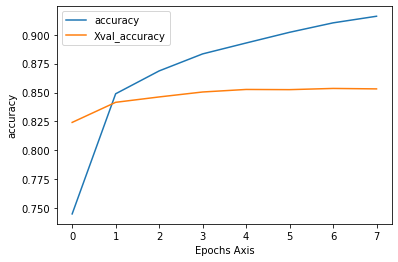

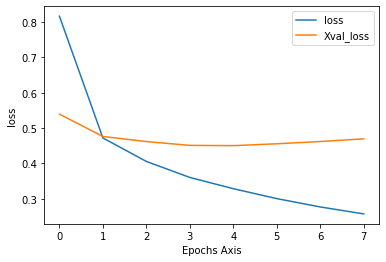

  MCB Evaluation Test Accuracy: 0.8551641702651978  Evaluation Test loss: 0.4667125940322876


In [26]:
#Second and Third MC model - Bidirections RNN LSTM aka mcb with optional weighting adjustments added in later defintions to RW

### MultiClassification(mc) model layer architecture defintion
### Use different vocabulary size as potential improvement option:

### Using .add for layer specification 
mcb_model = tf.keras.Sequential()
# Changed layers, Dense values etc in model tuning to get this
mcb_model.add(Embedding(updated_size, embed_dim, input_length=max_len))


# Bidirectional LSTM 
mcb_model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   

mcb_model.add(GlobalMaxPool1D())

#mc_model.add(SpatialDropout1D(0.2))  # BAT Try with drop-out here and in LSTM layer only...for overfitting issues
#OLD mc_model.add(GlobalAveragePooling1D())
#mcb_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
mcb_model.add(Dense(9, activation = 'softmax')) 
############# BAT - Many, Many changes in above and below layers to handle 9 label MC #####
mcb_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print("CFPB LSTM mcb Model 1 Summary", end ='\n')
mcb_model.summary()

##############

### BAT Perform mc_model.fit using callbacks with stop_monitor specification and validation data 
mcb_history = mcb_model.fit(Xtrain_padded, y_train_np, batch_size=batch_size, epochs=11, validation_data=(Xval_padded, y_val_np), callbacks=[stop_monitor], verbose=3)

### BAT - Provide visualizations of accuracy and val_loss through epoch intervals
plot_graphs(mcb_history, "accuracy")
plot_graphs(mcb_history, "loss")

### D.3 Evaluate Test set and print Accuracy and Loss to assess fitness
result = mcb_model.evaluate(Xtest_padded, y_test_np, verbose=0)
print(f'  MCB Evaluation Test Accuracy: {result[1]}  Evaluation Test loss: {result[0]}')

# Prediction and Scoring analysis

In [28]:
#Prediction code

# Prediction on Test Data
predict_mcb = mcb_model.predict(Xtest_padded)
predict_mcb

array([[1.3783771e-04, 7.7638042e-04, 9.7388566e-01, ..., 4.7377012e-05,
        3.8691378e-05, 3.7105186e-04],
       [1.3992694e-03, 5.9347000e-02, 9.0371853e-01, ..., 1.5021751e-03,
        6.0196494e-04, 2.1084227e-02],
       [1.3870063e-05, 1.3135739e-04, 9.9909806e-01, ..., 1.2553738e-05,
        1.0898454e-05, 1.3154579e-04],
       ...,
       [5.6182007e-06, 5.7361201e-05, 9.9972862e-01, ..., 5.3275826e-06,
        6.6310172e-06, 2.5834435e-05],
       [5.7452609e-04, 4.8148078e-03, 7.7801794e-01, ..., 1.6067976e-03,
        8.4974214e-05, 1.7668005e-03],
       [4.9450891e-06, 7.5630429e-05, 9.9970800e-01, ..., 8.1732833e-06,
        4.6934051e-06, 4.6306570e-05]], dtype=float32)

In [36]:
# 'mcb' Model prediction analysis metrics for goal target assessment

precision, recall, fscore, support = metrics(y_test_np, predict_mcb.round())
display({ i : ((l_encode.classes_).tolist())[i] for i in range(0, len((l_encode.classes_).tolist()) ) })
print('-------------------------------------------------------------------------')
print(sklearn.metrics.classification_report(y_test_np, predict_mcb.round()))

{0: 'Checking or savings account',
 1: 'Credit card or prepaid card',
 2: 'Credit reporting, credit repair services, or other personal consumer reports',
 3: 'Debt collection',
 4: 'Money transfer, virtual currency, or money service',
 5: 'Mortgage',
 6: 'Payday loan, title loan, or personal loan',
 7: 'Student loan',
 8: 'Vehicle loan or lease'}

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      3012
           1       0.78      0.71      0.74      4110
           2       0.91      0.93      0.92     27561
           3       0.84      0.76      0.80      8566
           4       0.86      0.70      0.77      2001
           5       0.92      0.87      0.90      3536
           6       0.63      0.19      0.29       583
           7       0.79      0.64      0.71       498
           8       0.67      0.52      0.59      1032

   micro avg       0.87      0.84      0.86     50899
   macro avg       0.79      0.68      0.72     50899
weighted avg       0.87      0.84      0.85     50899
 samples avg       0.84      0.84      0.84     50899



c:\Users\bradt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


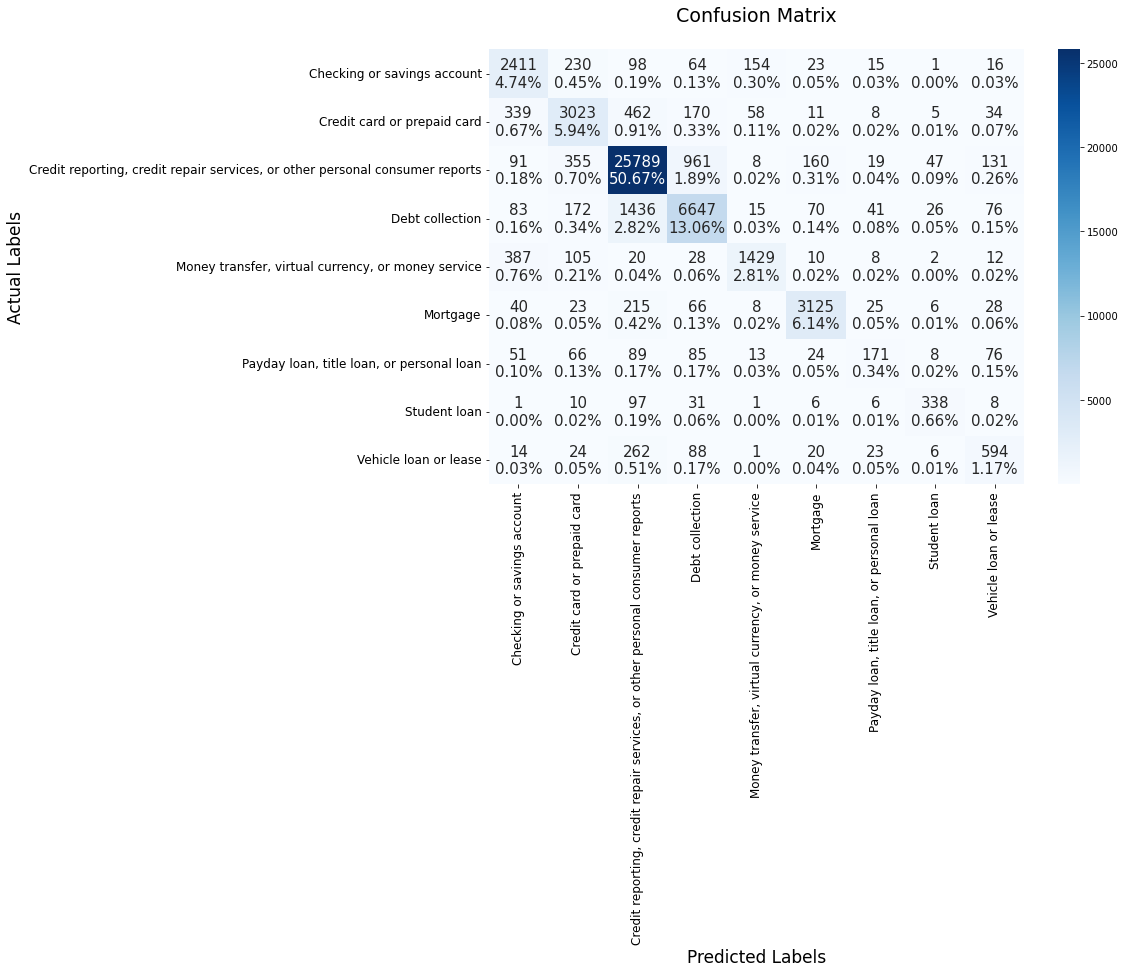

In [37]:
# Optional Confusion Matrix

 # Declaring function for plotting confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, test_data, test_labels):
    
    products = ['Checking or savings account', 'Credit card or prepaid card', 'Credit reporting, credit repair services, or other personal consumer reports', \
        'Debt collection', 'Money transfer, virtual currency, or money service', 'Mortgage', 'Payday loan, title loan, or personal loan', 'Student loan', \
            'Vehicle loan or lease']
        
    # Calculate predictions
    pred = model.predict(test_data)
    
    # Declaring confusion matrix
    cm = confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(pred, axis=1))
    
    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(9,9)

    # Plotting confusion matrix
    plt.figure(figsize=(12,8))
    
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)
    
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)
    
plot_cm(mcb_model, Xtest_padded, y_test_np)

CFPB LSTM RW Model Summary
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 300, 81)           4044735   
                                                                 
 bidirectional_25 (Bidirecti  (None, 300, 128)         74752     
 onal)                                                           
                                                                 
 global_max_pooling1d_20 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_35 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 4,120,648
Trainable params: 4,120,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
Epoch 

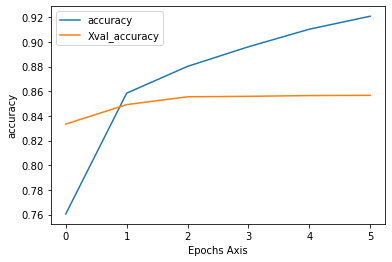

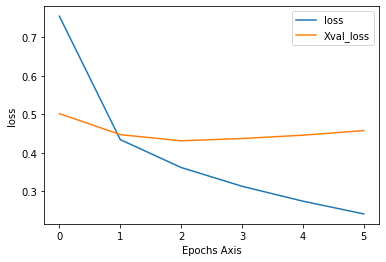

  RW Evaluation Test Accuracy: 0.8600365519523621  Evaluation Test loss: 0.44975993037223816


In [92]:
# Trial for multiclass improvments: re-weighting categories
# AKA rw_model
# Re-weighting of product label classes
# Classes not needing extra such as credit check will be a 1, other will be x times 1.
# for example #6 is payday loans, which we will start at 2 and perhaps raise to 3, #0 at 1 then to 2
product_weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 2}
# Bug Bug Bug Bug Bug Bug Bug:
# After multiple trials, I've determined that tf.keras class weighting DOES NOT WORK at this time. Validated bug reports:
# https://github.com/tensorflow/tensorflow/issues/41448

rw_model = tf.keras.Sequential()
# Changed layers, Dense values etc in model tuning to get this
rw_model.add(Embedding(updated_size, embed_dim, input_length=max_len))

# Bidirectional LSTM 
rw_model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0)))   # tried 32, and 0.4 too

rw_model.add(GlobalMaxPool1D()) # this workded better than '...Average...'

rw_model.add(Dense(9, activation = 'softmax')) 
#Note changes made in Dense output layer and the compile parameters for 9 labels
rw_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # tried both adam and rmsprop 

print("CFPB LSTM RW Model Summary", end ='\n')
rw_model.summary()

### Perform rw_model.fit using class weight (now removed b/c of Keras and Tensorflow not having weighting working) 
rw_history = rw_model.fit(Xtrain_padded, y_train_np, batch_size=batch_size, epochs=8, validation_data=(Xval_padded, y_val_np), callbacks=[stop_monitor], verbose=3)
# 5/19 removed class weight

### BAT - Provide visualizations of accuracy and val_loss through epoch intervals
plot_graphs(rw_history, "accuracy")
plot_graphs(rw_history, "loss")

### Evaluate Test set and print Accuracy and Loss to assess fitness
result = rw_model.evaluate(Xtest_padded, y_test_np, verbose=0)
print(f'  RW Evaluation Test Accuracy: {result[1]}  Evaluation Test loss: {result[0]}')

In [ ]:
#Formal model inputs and outputs
#plot_model(rw_model,show_shapes=True)

In [82]:
# RW Prediction code

# RW Prediction on Test Data
predict_rw = rw_model.predict(Xtest_padded)
predict_rw

array([[1.4938340e-04, 3.7285513e-03, 9.5099962e-01, ..., 7.6462963e-04,
        1.1185153e-03, 2.7082958e-03],
       [2.9194541e-03, 1.3339485e-01, 7.9296279e-01, ..., 1.2961431e-02,
        6.5551391e-03, 3.4449004e-02],
       [2.2040859e-04, 2.7140328e-03, 9.9099731e-01, ..., 1.8886900e-04,
        1.6950771e-04, 8.2352984e-04],
       ...,
       [2.8013525e-04, 1.9074046e-03, 9.9357456e-01, ..., 1.4446638e-04,
        1.2013117e-04, 6.6840020e-04],
       [8.9415436e-04, 1.0131880e-02, 5.2855784e-01, ..., 1.6319355e-02,
        3.6447418e-03, 3.6075530e-03],
       [5.3315187e-05, 8.9800690e-04, 9.9241227e-01, ..., 1.1265404e-04,
        1.6682643e-04, 4.8905384e-04]], dtype=float32)

In [83]:
# RW Model prediction analysis metrics for goal assessment
precision, recall, fscore, support = metrics(y_test_np, predict_rw.round())
display({ i : ((l_encode.classes_).tolist())[i] for i in range(0, len((l_encode.classes_).tolist()) ) })
print('-------------------------------------------------------------------------')
print(sklearn.metrics.classification_report(y_test_np, predict_rw.round()))

{0: 'Checking or savings account',
 1: 'Credit card or prepaid card',
 2: 'Credit reporting, credit repair services, or other personal consumer reports',
 3: 'Debt collection',
 4: 'Money transfer, virtual currency, or money service',
 5: 'Mortgage',
 6: 'Payday loan, title loan, or personal loan',
 7: 'Student loan',
 8: 'Vehicle loan or lease'}

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      3012
           1       0.79      0.73      0.76      4110
           2       0.92      0.92      0.92     27561
           3       0.83      0.75      0.79      8566
           4       0.89      0.73      0.80      2001
           5       0.93      0.85      0.89      3536
           6       0.79      0.02      0.04       583
           7       0.74      0.65      0.69       498
           8       0.79      0.38      0.52      1032

   micro avg       0.88      0.83      0.85     50899
   macro avg       0.83      0.64      0.68     50899
weighted avg       0.88      0.83      0.85     50899
 samples avg       0.83      0.83      0.83     50899



c:\Users\bradt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
